## Import libraries

In [4]:
from http.client import HTTPSConnection
from base64 import b64encode
from json import loads
from json import dumps

import pandas as pd
from dotenv import load_dotenv

from transformers import pipeline
import nltk
import re
from collections import Counter

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

## Client

In [5]:
class RestClient:
    domain = "api.dataforseo.com"

    def __init__(self, username, password):
        self.username = username
        self.password = password

    def request(self, path, method, data=None):
        connection = HTTPSConnection(self.domain)
        try:
            base64_bytes = b64encode(
                ("%s:%s" % (self.username, self.password)).encode("ascii")
                ).decode("ascii")
            headers = {'Authorization' : 'Basic %s' %  base64_bytes, 'Content-Encoding' : 'gzip'}
            connection.request(method, path, headers=headers, body=data)
            response = connection.getresponse()
            return loads(response.read().decode())
        finally:
            connection.close()

    def get(self, path):
        return self.request(path, 'GET')

    def post(self, path, data):
        if isinstance(data, str):
            data_str = data
        else:
            data_str = dumps(data)
        return self.request(path, 'POST', data_str)


### fetch data

In [ ]:
restclient_email = os.getenv("RESTCLIENT_EMAIL")
restclient_password = os.getenv("RESTCLIENT_PASSWORD")

In [6]:
client = RestClient(restclient_email, restclient_password)

In [11]:
post_data = dict()

In [12]:
post_data[len(post_data)] = dict(    
    app_id="org.telegram.messenger",
    language_code="en",
    location_code=2840,
    depth=150
) 

In [13]:
response = client.post("/v3/app_data/google/app_reviews/task_post", post_data)

In [ ]:
id = "02181138-9185-0425-0000-1faf50ee7828"
response = client.get("/v3/app_data/google/app_reviews/task_get/advanced/" + id)

if response["status_code"] == 20000:
    print(response)

In [8]:
items = response['tasks'][0]['result'][0]['items']

data = {
    'rating': [item['rating']['value'] for item in items],
    'id': [item['id'] for item in items],
    'title': [item['title'] for item in items],
    'review_text': [item['review_text'] for item in items]
}

df = pd.DataFrame(data)

## EDA

<Axes: >

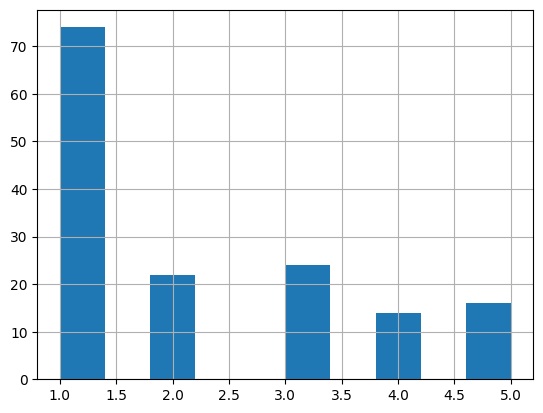

In [42]:
df.rating.hist()

In [19]:
df['rating'].mean()

2.1733333333333333

In [20]:
df['rating'].value_counts(normalize=True) * 100

rating
1    49.333333
3    16.000000
2    14.666667
5    10.666667
4     9.333333
Name: proportion, dtype: float64

In [21]:
df.isna().sum()

rating           0
id               0
title          150
review_text      0
dtype: int64

## Sentiment analysis 

In [24]:
sentiment_pipeline = pipeline("text-classification", model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

df['sentiment'] = df['review_text'].apply(lambda text: sentiment_pipeline(text)[0]['label'])

Device set to use cpu


In [34]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vhodlevskyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/vhodlevskyi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
negative_reviews = df[df['sentiment'] == 'negative']['review_text']

In [35]:
def extract_keywords(text):
    words = re.findall(r'\b\w+\b', text.lower())  
    words = [word for word in words if word not in stop_words] 
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

all_words = [word for review in negative_reviews for word in extract_keywords(review)]

word_counts = Counter(all_words)

common_keywords = word_counts.most_common(20)

common_keywords

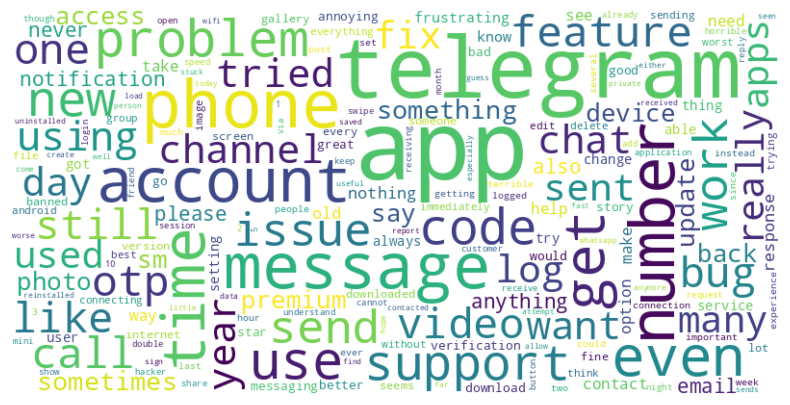

In [41]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [48]:
negative_reviews.iloc[1]

"Since the most recent update, there seems to be a new feature that I can't switch off. When I reply to messages from my notification bar, and the message I'm replying to is now shown in an extra area of the chat bubble. My replies sent from fully opening the app appear normal as they always have. It clutters up my screen, and the difference is visible to the message recipient. If there's a way to shut it off, I would give more stars."

In [49]:
len(negative_reviews)/len(df)

0.76

In [ ]:
The distribution of ratings proves that most of the reviews are supposed to be negative:
Rating percentage 
1    49.333333
2    14.666667
3    16.000000
4     9.333333
5    10.666667